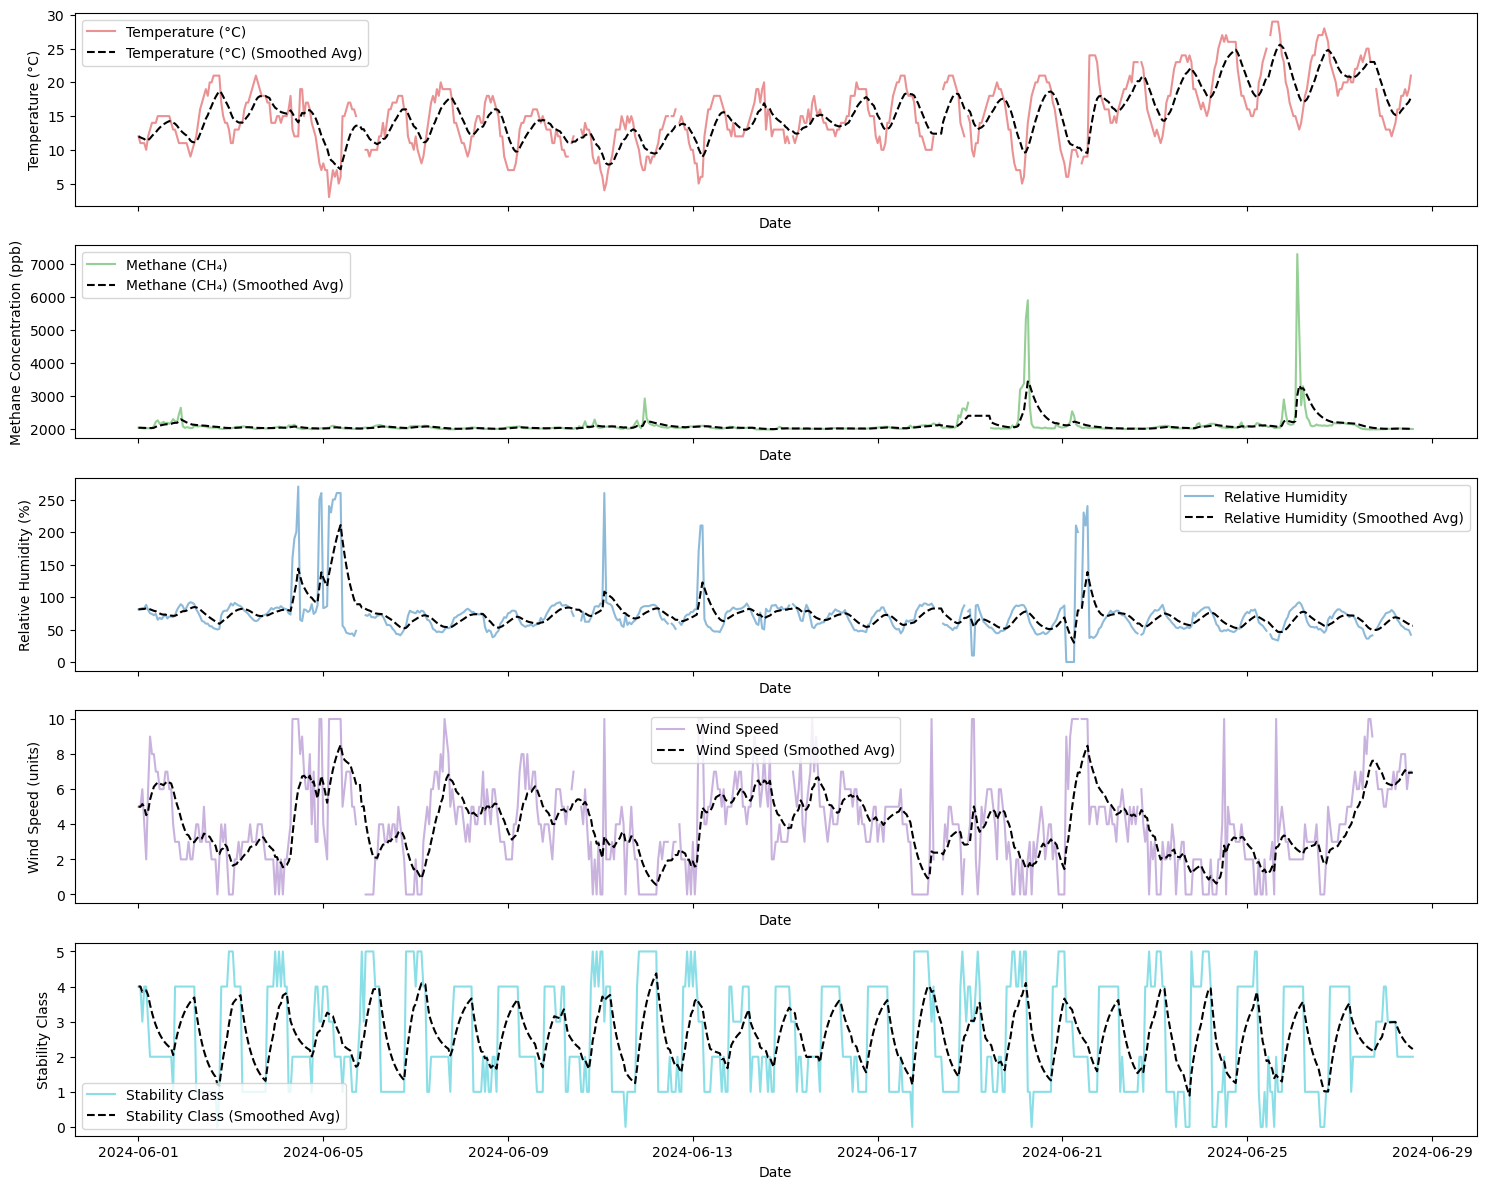

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from windrose import WindroseAxes

# Load the dataset
file_path = 'data/msr_ch4_met_hrly_310524_270924.csv'
try:
    data = pd.read_csv(file_path)

    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

    # Filter data to only include June and July 2024
    data = data[(data['date'] >= '2024-06-01') & (data['date'] <= '2024-07-01')]
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()
except pd.errors.EmptyDataError:
    print(f"Error: The file {file_path} is empty.")
    exit()
except pd.errors.ParserError:
    print(f"Error: The file {file_path} could not be parsed.")
    exit()

# Function to determine Pasquill-Gifford stability class
def determine_stability_class(row):
    hour = row['date'].hour
    wind_speed = row['ws']
    
    if 6 <= hour <= 18:  # Daytime hours (approx. 6 AM to 6 PM)
        if wind_speed < 2:
            return 'A'  # Very Unstable
        elif 2 <= wind_speed <= 5:
            return 'B'  # Moderately Unstable
        else:
            return 'C'  # Slightly Unstable
    else:  # Nighttime hours
        if wind_speed < 2:
            return 'F'  # Stable
        elif 2 <= wind_speed <= 5:
            return 'E'  # Slightly Stable
        else:
            return 'D'  # Neutral

# Apply the function to the dataframe
data['stability_class'] = data.apply(determine_stability_class, axis=1)

# Function to create individual time series subplots with rolling average
def plot_time_series_subplot(ax, x, y, ylabel, label, color, window):
    rolling_avg = y.ewm(span=window, adjust=False).mean()
    ax.plot(x, y, label=label, color=color, alpha=0.5)
    ax.plot(x, rolling_avg, label=f'{label} (Smoothed Avg)', color='black', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['temp'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['rh'], 'Relative Humidity (%)', 'Relative Humidity', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], data['date'], data['ws'], 'Wind Speed (units)', 'Wind Speed', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'], stability_class_numeric, 'Stability Class', 'Stability Class', 'tab:cyan', window)

    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)

<Figure size 1000x600 with 0 Axes>

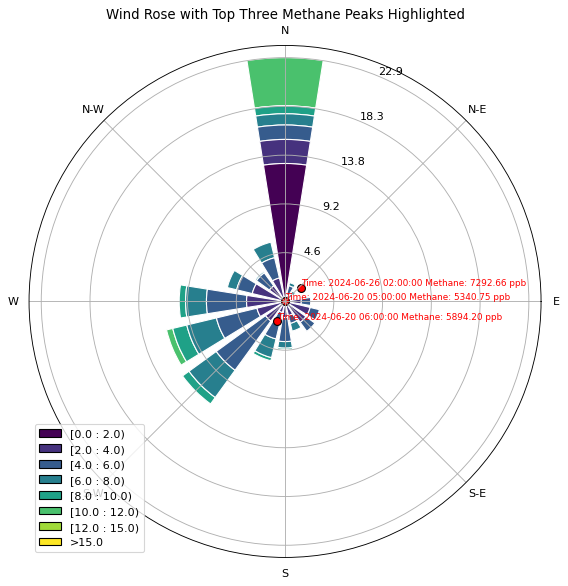

Maximum Methane Concentration: 7292.661169 ppb
Time: 2024-06-26 02:00:00
Wind Speed: 2.0
Wind Direction: 340.0
Pasquill-Gifford Stability Class: E


In [6]:
# Plot Wind Rose Chart with Methane Peaks Highlighted
plt.figure(figsize=(10, 6))
ax = WindroseAxes.from_ax()
custom_bins = [0, 2, 4, 6, 8, 10, 12, 15]
ax.bar(data['wd'], data['ws'], bins=custom_bins, normed=True, opening=0.8, edgecolor='white')

# Highlight the wind direction and speed at the top three methane concentrations
max_methane_rows = data.nlargest(3, 'ch4_ppb')
for idx, row in max_methane_rows.iterrows():
    label = f'Methane Peak {idx + 1}' if idx == 0 else None  # Avoid duplicate labels in the legend
    ax.scatter(row['wd'], row['ws'], color='red', s=50, label=label, edgecolor='black')
    ax.text(row['wd'], row['ws'], f"Time: {row['date']} Methane: {row['ch4_ppb']:.2f} ppb", fontsize=8, color='red', ha='left', va='bottom')

ax.set_title('Wind Rose with Top Three Methane Peaks Highlighted')
ax.set_legend(title='Wind Speed (units)')
plt.legend()
plt.show()

# Find the maximum methane concentration and related data
max_methane_idx = data['ch4_ppb'].idxmax()
max_methane_row = data.loc[max_methane_idx]
max_methane_value = max_methane_row['ch4_ppb']
max_methane_time = max_methane_row['date']
max_methane_ws = max_methane_row['ws']
max_methane_wd = max_methane_row['wd']
max_methane_stability = max_methane_row['stability_class']

print(f"Maximum Methane Concentration: {max_methane_value} ppb")
print(f"Time: {max_methane_time}")
print(f"Wind Speed: {max_methane_ws}")
print(f"Wind Direction: {max_methane_wd}")
print(f"Pasquill-Gifford Stability Class: {max_methane_stability}")

(2000, 2000, 50)


/home/sam0fc/miniconda3/envs/gaussian_mixing/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


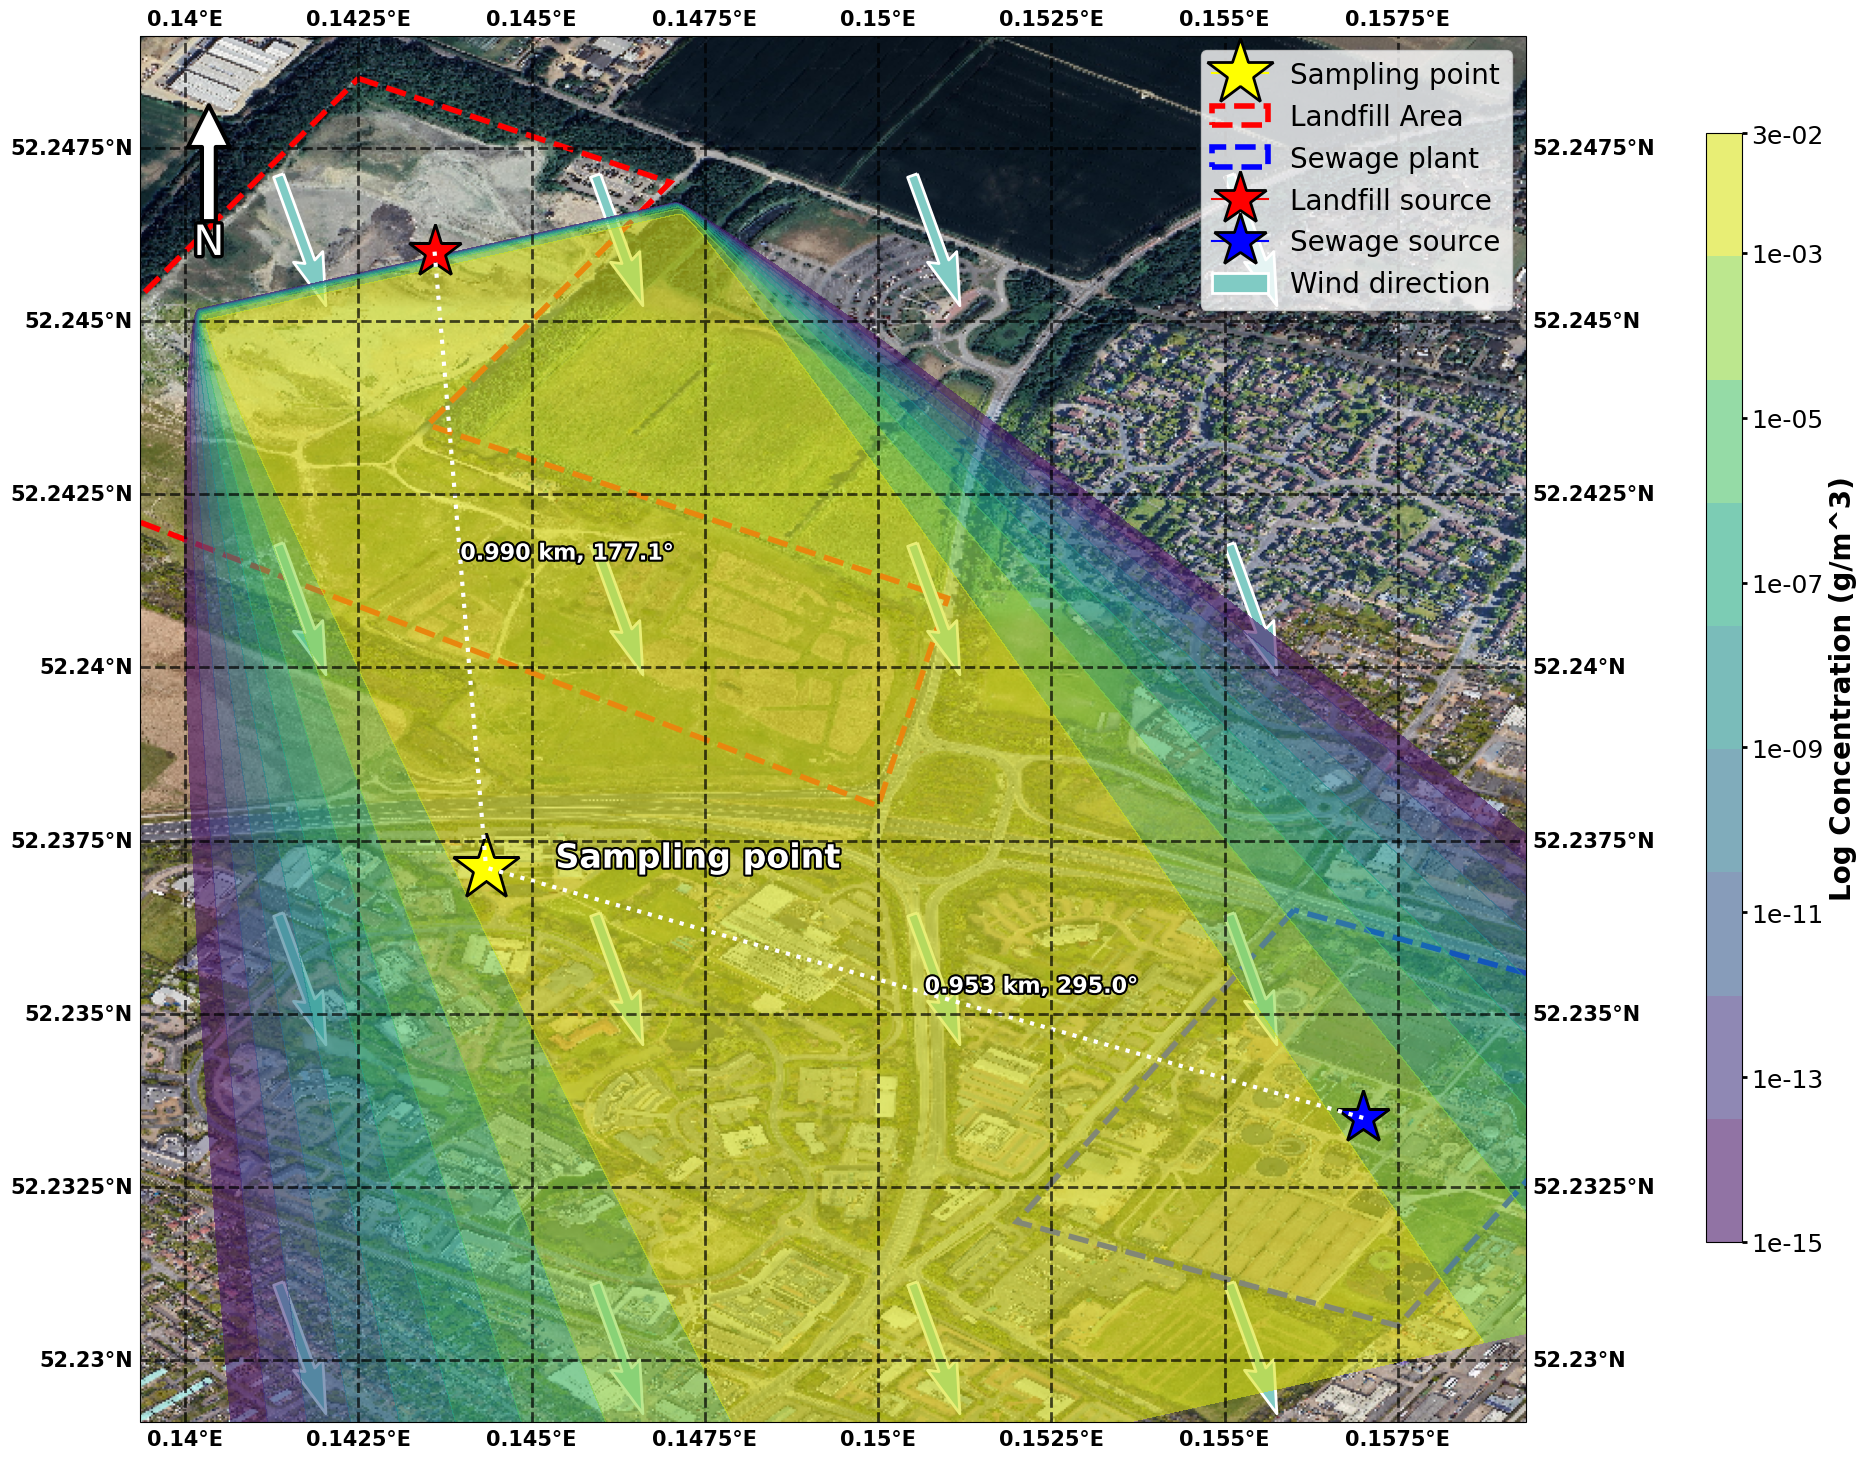

(2000, 2000, 50)


In [37]:
import numpy as np
from matplotlib import pyplot as plt
import flux_maps as maps
import flux_model as model

importlib.reload(sys.modules['flux_model'])

# Parameters
q = 1.0       # Emission rate in grams per second
u = 2.0       # Wind speed in meters per second
h = 10.0      # Effective stack height in meters
ls = 500.0    # Source width in meters
case = 4     # Atmospheric stability class (0-based index, from 0 to 5)
wind_angle = 340

# Sources, lon and lat
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)
sampler = (0.144343, 52.237111)

fig, ax = maps.base_map(landfill, sewage, sampler)

# Adding wind arrows to the map
fig, ax = maps.add_wind_direction(ax, wind_angle)

# Create the coordinate grids
x = np.linspace(0, 2000, 2000)
y = np.linspace(-1000, 1000, 2000)
z = np.linspace(0, 700, 50)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# Compute the concentration data
concentration = model.conc_line(q, u, X, Y, Z, h, ls, case)

fig, ax, plume_data = maps.add_plume_contours(fig, ax, landfill[0], landfill[1], concentration, X, Y, z, theta_deg=wind_angle, z_height=10)

# Show the resulting map with contours
plt.show()
print(concentration.shape)

In [8]:
import numpy as np

def find_closest_index(lon_values, lat_values, target_lon, target_lat):
    """
    Finds the index of the coordinate in the lon_values and lat_values arrays that is closest to the target coordinate.

    Parameters:
    lon_values (array-like): Array of longitude values from the mesh grid.
    lat_values (array-like): Array of latitude values from the mesh grid.
    target_lon:q (float): Longitude of the target coordinate.
    target_lat (float): Latitude of the target coordinate.

    Returns:
    tuple: Index (i, j) of the closest matching coordinate.
    """
    # Convert to numpy arrays
    lon_values = np.array(lon_values)
    lat_values = np.array(lat_values)
    
    # Calculate the distance between each coordinate and the target coordinate
    distances = np.sqrt((lon_values - target_lon)**2 + (lat_values - target_lat)**2)
    
    # Find the index of the minimum distance
    min_index = np.unravel_index(np.argmin(distances), distances.shape)
    
    return min_index

closest_index = find_closest_index(plume_data[0], plume_data[1], sampler[0], sampler[1])

print(closest_index)

concentration_at_sampler = plume_data[2][closest_index]
print(concentration_at_sampler)

(np.int64(473), np.int64(354))
0.0027101165255924006


In [9]:
def g_m3_to_ppm(methane_g_m3, temperature=273.15, pressure=101325):
    # Constants
    MOLAR_MASS_METHANE = 16.04  # g/mol for methane (CH4)
    R = 8.314  # J/(mol*K), ideal gas constant
    
    # Calculate the molar concentration of methane in mol/m^3
    molar_concentration = methane_g_m3 / MOLAR_MASS_METHANE  # mol/m^3
    
    # Calculate volume at specified conditions (temperature in Kelvin, pressure in Pascals)
    molar_volume = R * temperature / pressure  # in m^3/mol (ideal gas law)
    
    # Convert molar concentration to ppm
    ppm = molar_concentration / molar_volume * 1e6
    
    return ppm

# Example usage
ppm_value = g_m3_to_ppm(concentration_at_sampler)
print(f"Methane concentration: {ppm_value:.2f} ppm")


Methane concentration: 7538.57 ppm


In [50]:
emission_rate = q 
wind_speed = u 
wind_direction = wind_angle 
source_height = h 
source_width = ls 
stability_class = chr(65 + case)

# Sources, lon and lat
landfill = (52.246, 0.1436)
sewage = (52.2335, 0.157)
sampler = (52.237111, 0.144343)

# Rotate line source with prevaling wind direction and reload imports

import sys 
import importlib

importlib.reload(sys.modules['point_sampler'])
importlib.reload(sys.modules['flux_model'])

from point_sampler import PointSampler
microsoft_sampler = PointSampler(sampler, source_height) 
microsoft_sampler.add_source(landfill, source_width, source_height)
concentration = microsoft_sampler.sample_concentration(wind_speed, stability_class, emission_rate, wind_direction)
ppm_value = g_m3_to_ppm(concentration)

print(f'{concentration=}')
print(f'{ppm_value=}')

IndexError: string index out of range

In [48]:
from point_sampler import PointSampler
import flux_model as model
importlib.reload(sys.modules['point_sampler'])
importlib.reload(sys.modules['flux_model'])


<module 'flux_model' from '/home/sam0fc/Documents/QCES/EDAA/MethanePlume/methane_flux/flux_model.py'>

(np.int64(1345), np.int64(466))
(np.int64(1331), np.int64(471))
(np.int64(1317), np.int64(477))
(np.int64(1303), np.int64(482))
(np.int64(1290), np.int64(486))


(np.int64(1276), np.int64(491))
(np.int64(1262), np.int64(497))
(np.int64(1249), np.int64(501))
(np.int64(1235), np.int64(506))
(np.int64(1221), np.int64(511))


(np.int64(1208), np.int64(516))
(np.int64(1194), np.int64(521))
(np.int64(1180), np.int64(526))
(np.int64(1166), np.int64(531))
(np.int64(1153), np.int64(536))


(np.int64(1139), np.int64(541))
(np.int64(1125), np.int64(546))
(np.int64(1111), np.int64(551))
(np.int64(1098), np.int64(556))
(np.int64(1084), np.int64(561))


(np.int64(1070), np.int64(566))
(np.int64(1057), np.int64(571))
(np.int64(1043), np.int64(576))
(np.int64(1029), np.int64(581))


(np.int64(1015), np.int64(586))
(np.int64(1002), np.int64(591))
(np.int64(988), np.int64(596))
(np.int64(974), np.int64(601))


(np.int64(961), np.int64(606))
(np.int64(947), np.int64(611))
(np.int64(933), np.int64(616))
(np.int64(919), np.int64(621))
(np.int64(906), np.int64(626))


(np.int64(892), np.int64(631))
(np.int64(878), np.int64(636))
(np.int64(864), np.int64(641))
(np.int64(851), np.int64(646))
(np.int64(837), np.int64(651))


(np.int64(823), np.int64(656))
(np.int64(810), np.int64(661))
(np.int64(796), np.int64(666))
(np.int64(782), np.int64(671))
(np.int64(768), np.int64(676))


(np.int64(755), np.int64(681))
(np.int64(741), np.int64(686))
(np.int64(727), np.int64(691))
(np.int64(713), np.int64(696))
(np.int64(700), np.int64(701))


(np.int64(686), np.int64(706))
(np.int64(672), np.int64(711))
(np.int64(659), np.int64(716))
(np.int64(645), np.int64(721))
(np.int64(631), np.int64(726))


(np.int64(617), np.int64(731))
(np.int64(604), np.int64(736))
(np.int64(590), np.int64(741))
(np.int64(576), np.int64(746))
(np.int64(562), np.int64(751))


(np.int64(549), np.int64(756))
(np.int64(535), np.int64(761))
(np.int64(521), np.int64(766))
(np.int64(508), np.int64(771))
(np.int64(494), np.int64(776))


(np.int64(480), np.int64(781))
(np.int64(466), np.int64(786))
(np.int64(453), np.int64(791))
(np.int64(439), np.int64(796))
(np.int64(425), np.int64(801))


(np.int64(411), np.int64(806))
(np.int64(398), np.int64(811))
(np.int64(384), np.int64(816))
(np.int64(370), np.int64(821))
(np.int64(357), np.int64(826))


(np.int64(343), np.int64(831))
(np.int64(329), np.int64(836))
(np.int64(315), np.int64(841))
(np.int64(302), np.int64(846))
(np.int64(288), np.int64(851))


(np.int64(274), np.int64(856))
(np.int64(261), np.int64(861))
(np.int64(247), np.int64(866))
(np.int64(233), np.int64(871))
(np.int64(219), np.int64(876))


(np.int64(206), np.int64(881))
(np.int64(192), np.int64(886))
(np.int64(178), np.int64(891))
(np.int64(164), np.int64(896))
(np.int64(151), np.int64(901))


(np.int64(137), np.int64(906))
(np.int64(123), np.int64(911))
(np.int64(110), np.int64(916))
(np.int64(96), np.int64(921))
(np.int64(82), np.int64(926))


(np.int64(68), np.int64(931))
(np.int64(55), np.int64(936))
(np.int64(41), np.int64(941))
(np.int64(27), np.int64(946))
(np.int64(13), np.int64(951))


(np.int64(0), np.int64(956))
(np.int64(0), np.int64(958))


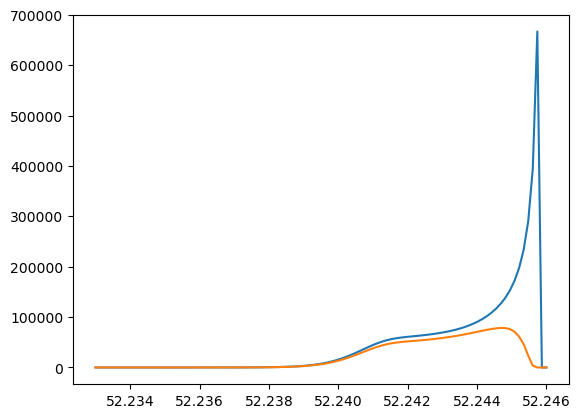

In [40]:
# Test the point sampler vs nearest index methods at various points in the plume range and plot 
range_lat = np.linspace(52.233, 52.246, 100)
range_lon = np.linspace(0.143, 0.143, 100) 

plume_grid_conc =[]
point_sample_conc = []

for lat, lon in zip(range_lat, range_lon):
    closest_index = find_closest_index(plume_data[0], plume_data[1], lon, lat)
    print(closest_index)
    concentration_at_sampler = plume_data[2][closest_index]
    ppm_plumegrid = g_m3_to_ppm(concentration_at_sampler)
    plume_grid_conc.append(ppm_plumegrid)

    # find with point sampler: 
    microsoft_sampler = PointSampler((lat, lon), source_height) 
    microsoft_sampler.add_source(landfill, source_width, source_height) 
    concentration = microsoft_sampler.sample_concentration(wind_speed, stability_class, emission_rate, wind_direction) 
    ppm_pointsample = g_m3_to_ppm(concentration)
    point_sample_conc.append(ppm_pointsample)

plt.plot(range_lat, point_sample_conc, label='Point Sampler')
plt.plot(range_lat, plume_grid_conc, label='Plume Grid')

In [51]:
sampler = (52.237111, 0.144343) 
source_height = 10 
landfill = (52.246, 0.1436)
microsoft_sampler = PointSampler(sampler, source_height) 
microsoft_sampler.add_source(landfill, source_width, source_height) 
concentration_model = microsoft_sampler.sample_concentration(data['ws'], data['stability_class'], q, data['wd'])


# Plot time series as above but with modelled concentration in both methods 
def plot_combined_time_series_with_model(data, window=12):
    fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['temp'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['rh'], 'Relative Humidity (%)', 'Relative Humidity', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], data['date'], data['ws'], 'Wind Speed (units)', 'Wind Speed', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'], stability_class_numeric, 'Stability Class', 'Stability Class', 'tab:cyan', window)

    # Plot Modelled Concentration
    plot_time_series_subplot(axes[5], data['date'], concentration_model, 'Modelled Concentration (ppm)', 'Modelled Concentration', 'tab:orange', window)

    plt.tight_layout()
    plt.show() 

plot_combined_time_series_with_model(data) 

ValueError: NumPy boolean array indexing assignment cannot assign 1942584 input values to the 324 output values where the mask is true